In [88]:
import zipfile
import pandas as pd
from nltk.tokenize import WordPunctTokenizer
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
from os.path import exists

In [89]:
if not exists('wiki_movie_plots_deduped.csv'):
    with zipfile.ZipFile('wiki_movie_plots_deduped.csv.zip', 'r') as zip_ref:
        zip_ref.extractall('.')

In [90]:
plots = pd.read_csv('wiki_movie_plots_deduped.csv')
plots.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [91]:
unique_genres_count = plots['Genre'].unique().shape[0]
print(f'Уникальных значений в поле жанр: {unique_genres_count}')

Уникальных значений в поле жанр: 2265


<AxesSubplot: title={'center': 'Количество релизов по годам'}, xlabel='Release Year'>

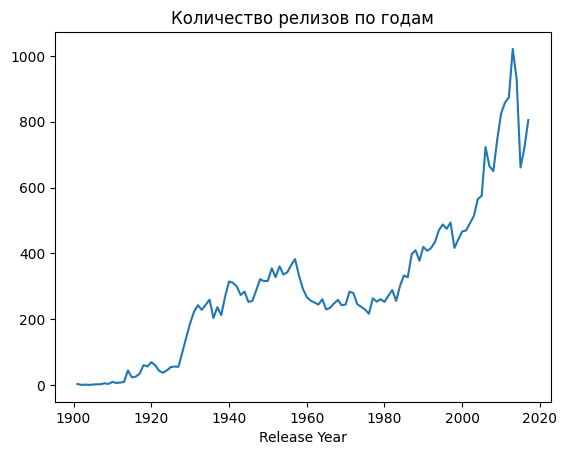

In [92]:
films_count_by_year = plots.groupby(['Release Year'])['Release Year'].count()
films_count_by_year.plot(title = 'Количество релизов по годам')

In [93]:
tokenizer = WordPunctTokenizer()
all_words = list()
for a, t in plots.iterrows():
    for cc in tokenizer.tokenize(t['Plot']):
        all_words.append(cc)
len_total_words_without_processing = len(all_words)
print(f'Общее количество уникальны слов без лемматизации и стемминга: {len_total_words_without_processing}')


Общее количество уникальны слов без лемматизации и стемминга: 15288663


In [94]:
# стемминг и лемматизация:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

set_stem_after_lem = set()
set_lem_after_stem = set()

lem = WordNetLemmatizer()
stem = PorterStemmer()

for a in tqdm(all_words):
    w1 = stem.stem(lem.lemmatize(a))
    set_stem_after_lem.add(w1)
    w2 = lem.lemmatize(stem.stem(a))
    set_lem_after_stem.add(w2)

count_stem_after_lem = len(set_stem_after_lem)
count_lem_after_stem = len(set_lem_after_stem)
print(f'Уникальных слов (стемминг после лемматизации): {count_stem_after_lem}')
print(f'Уникальных слов (лемматизация после стемминга: {count_lem_after_stem}')

100%|██████████| 15288663/15288663 [07:29<00:00, 34048.87it/s]

Уникальных слов (стемминг после лемматизации): 104531
Уникальных слов (лемматизация после стемминга: 104365


In [95]:
def get_sentiment(obj: tuple):
    neg = obj['neg']
    neu = obj['neu']
    pos = obj['pos']
    if neg > neu:
        if neg > pos:
            return 'neg'
        else:
            return 'pos'
    else:
        if neu > pos:
            return 'neu'
        else:
            return 'pos'

sia = SentimentIntensityAnalyzer()
sentiments = list()
limit = 1000
current_iteration = 0
for a, t in tqdm(plots.iterrows()):
    current_result = get_sentiment(sia.polarity_scores(t['Plot']))
    sentiments.append(current_result)
    current_iteration+=1
negatives_count = sentiments.count('neg')
postigive_count = sentiments.count('pos')
neutral_count   = sentiments.count('neu')
print(f'Статистика по polarity_score на сырых данных сюжета: negative: {negatives_count}, positive: {postigive_count}, neutral: {neutral_count}')

34886it [01:53, 306.32it/s]

Статистика по polarity_score на сырых данных сюжета: negative: 16, positive: 5, neutral: 34865


<AxesSubplot: title={'center': 'Количество фильмов с разным sentiment'}, xlabel='Sentiment'>

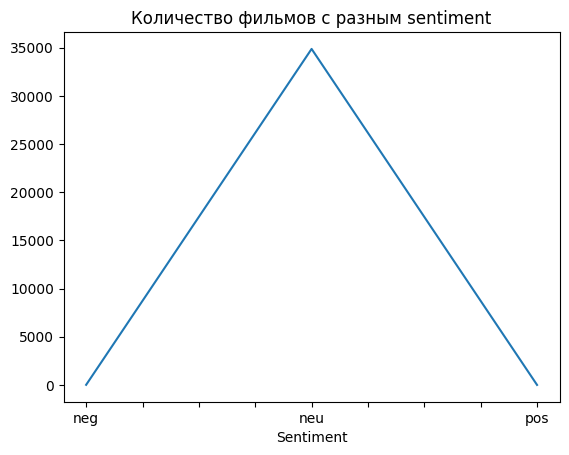

In [96]:
plots['Sentiment'] = sentiments
plots.head()
films_count_by_year = plots.groupby(['Sentiment'])['Title'].count()
films_count_by_year.plot(title = 'Количество фильмов с разным sentiment')
